1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
Predicted Skin Type: Dry


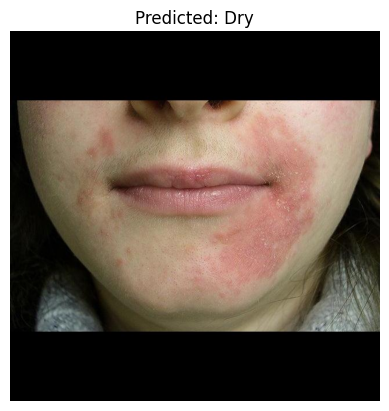

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os


def load_data(data_dir="datasets/skin-type", img_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        subset="training",
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation",
    )

    return train_generator, val_generator


def build_model(num_classes):
    base_model = keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )
    base_model.trainable = False  # Freeze base model layers

    model = keras.Sequential(
        [
            base_model,
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def train_model(
    model, train_generator, val_generator, epochs=10, model_path="skin_type_model.h5"
):
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)
    model.save(model_path)
    return history


def load_model(model_path="skin_type_model.h5"):
    return keras.models.load_model(model_path)


def plot_training_history(history):
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


def predict_skin_type(model, image_path, img_size=(224, 224), train_generator=None):
    image = keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = keras.preprocessing.image.img_to_array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    if train_generator:
        class_names = list(train_generator.class_indices.keys())
    else:
        class_names = ["Dry", "Normal", "Oily"]
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    print(f"Predicted Skin Type: {predicted_class}")

    # Show the image with predicted label
    image = keras.preprocessing.image.load_img(image_path)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()


# if __name__ == "__main__":
#     data_dir = "datasets/skin-type"  # Updated dataset directory
#     train_generator, val_generator = load_data(data_dir)
#     model = build_model(train_generator.num_classes)
#     history = train_model(model, train_generator, val_generator)
#     plot_training_history(history)
#     model = load_model()
#     predict_skin_type(model, "test_dry.jpg")
    
if __name__ == "__main__":
    model = load_model()
    predict_skin_type(model, "test_dry.jpg")